## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout, regularizers

def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128],
              use_bn=True,
              drp_ratio=0.,
              l2_ratio=0.):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)

            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 3
BATCH_SIZE = 128
# 使用不同dropout, regularizers, batch-normalization 等
DRP_RATIO = [0., 0.4, 0.8]
L2_RATIO = [0., 1e-6, 1e-8]
USE_BN = [True, False]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    # exp_name_tag = ("exp-%s" % (i))
    exp_name_tag = "exp-bn-%s-drp-%s-l2-%s" % (str(use_bn), str(drp_ratio), str(l2_ratio))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}




Numbers of exp: 0, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 10s 195us/step - loss: 1.6114 - acc: 0.4256 - val_loss: 1.8831 - val_acc: 0.3175
Epoch 2/3
50000/50000 [==============================] - 8s 165us/step - loss: 1.3766 - acc: 0.5099 - val_loss: 1.6590 - val_acc: 0.4162
Epoch 3/3
50000/50000 [==============================] - 8s 166us/step - loss: 1.2578 - acc: 0.5531 - val_loss: 1.7425 - val_acc: 0.3899
Numbers of exp: 3, with bn: True, drp_ratio: 0.40, l2_ratio: 0.00
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
___________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 10s 202us/step - loss: 1.9470 - acc: 0.3099 - val_loss: 1.7815 - val_acc: 0.3570
Epoch 2/3
50000/50000 [==============================] - 8s 169us/step - loss: 1.6788 - acc: 0.3984 - val_loss: 1.6795 - val_acc: 0.3964
Epoch 3/3
50000/50000 [==============================] - 8s 169us/step - loss: 1.5900 - acc: 0.4329 - val_loss: 1.6070 - val_acc: 0.4225
Numbers of exp: 6, with bn: True, drp_ratio: 0.80, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 10s 201us/step - loss: 2.7034 - acc: 0.1369 - val_loss: 2.1001 - val_acc: 0.2694
Epoch 2/3
50000/50000 [==============================] - 9s 171us/step - loss: 2.1415 - acc: 0.1920 - val_loss: 1.9820 - val_acc: 0.2772
Epoch 3/3
50000/50000 [==============================] - 9s 171us/step - loss: 2.0349 - acc: 0.2275 - val_loss: 1.8935 - val_acc: 0.2984
Numbers of exp: 9, with bn: False, drp_ratio: 0.00, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 6s 129us/step - loss: 2.1409 - acc: 0.1948 - val_loss: 1.9618 - val_acc: 0.2901
Epoch 2/3
50000/50000 [==============================] - 6s 117us/step - loss: 2.0113 - acc: 0.2422 - val_loss: 1.9245 - val_acc: 0.2874
Epoch 3/3
50000/50000 [==============================] - 6s 118us/step - loss: 1.9737 - acc: 0.2587 - val_loss: 1.9297 - val_acc: 0.2967
Numbers of exp: 13, with bn: False, drp_ratio: 0.40, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 7s 145us/step - loss: 2.4864 - acc: 0.0984 - val_loss: 2.3039 - val_acc: 0.1000
Epoch 2/3
50000/50000 [==============================] - 6s 126us/step - loss: 2.3040 - acc: 0.0967 - val_loss: 2.3039 - val_acc: 0.1001
Epoch 3/3
50000/50000 [==============================] - 6s 125us/step - loss: 2.3043 - acc: 0.0978 - val_loss: 2.3039 - val_acc: 0.1000
Numbers of exp: 17, with bn: False, drp_ratio: 0.80, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________

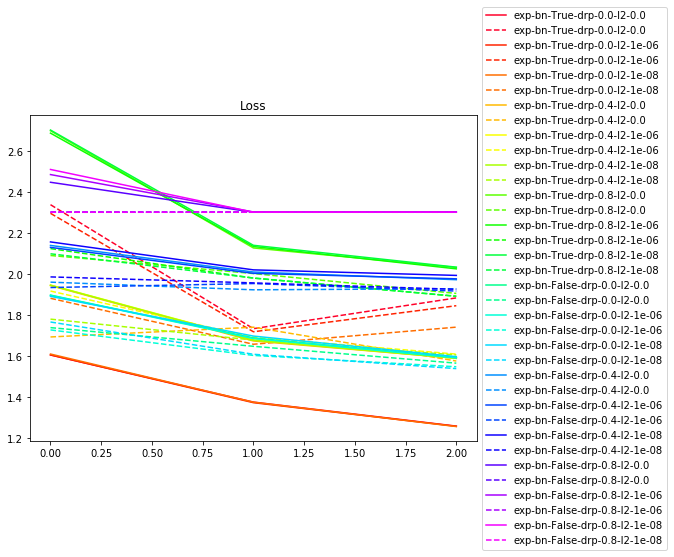

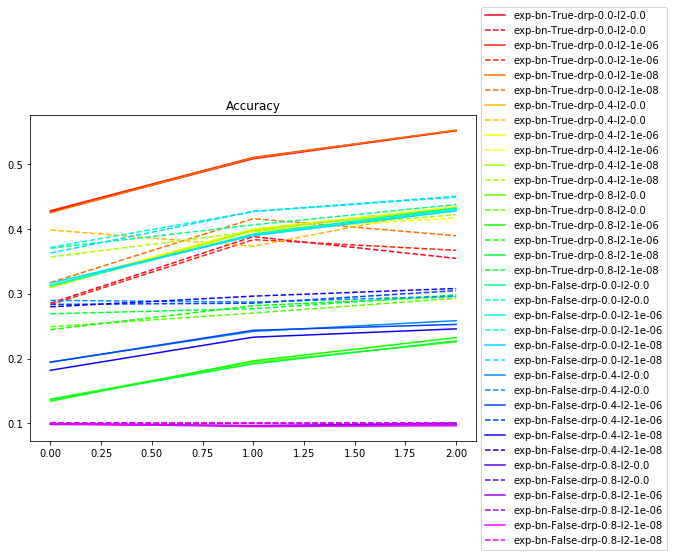

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
# 顏色太多種
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()